### 1. Answer the following:
**a. What is the outcome?**  
*chdfate, or whether the patient developed coronary heart disease (CHD) at end of follow-up.*  

**b. What are the predictors researchers are interested in?**  
- *Patient gender (__sex__)*
- *Systolic blood pressure, mm Hg (__sbp__)*
- *Diastolic blood pressure, mm Hg (__dbp__)*
- *Serum cholesterol, mg/100 ml (__scl__)*
- *Age at baseline exam, years (__age__)*
- *Body mass index, kg/m2 (__bmi__)*
- *Month of year of baseline exam (__month__)*

**c. What is the hypothesis?**  
*The hypothesis is that whether patient developed CHD at follow-up will be dependent on at least one of the above variables, or at least one coefficient of these variables in the logistic regression model would not be 0.*  
*The null hypothesis would say that whether the patient developed CHD at follow-up is not dependent on any of the above variables, or the coefficient of these variables in the logistic regression model would all be 0.*

### 2. Import the data, print out a few rows, and compute summary statistics. Is there missing data or other concerns?

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
chd = pd.read_excel("../W10/framingham_dataset_mod.xlsx")
chd.head()

,id,sex,sbp,dbp,scl,age,bmi,month,chdfate
0,2642,1,120,80,267.0,55,25.0,8,1
1,4627,1,130,78,192.0,53,28.4,12,1
2,2568,1,144,90,207.0,61,25.1,8,1
3,4192,1,92,66,231.0,48,26.2,11,1
4,3977,1,162,98,271.0,39,28.4,11,1


In [3]:
chd["chdfate"].unique()

array([1, 0])

In [4]:
chd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4695 entries, 0 to 4694
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       4695 non-null   int64  
 1   sex      4695 non-null   int64  
 2   sbp      4695 non-null   int64  
 3   dbp      4695 non-null   int64  
 4   scl      4662 non-null   float64
 5   age      4695 non-null   int64  
 6   bmi      4686 non-null   float64
 7   month    4695 non-null   int64  
 8   chdfate  4695 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 330.2 KB


In [5]:
chd["scl"].isnull().sum(), chd["bmi"].isnull().sum()

(33, 9)

In [6]:
chd.describe()

,id,sex,sbp,dbp,scl,age,bmi,month,chdfate
count,4695.000000,4695.000000,4695.000000,4695.000000,4662.000000,4695.000000,4686.000000,4695.000000,4695.000000
mean,2350.365282,1.563791,132.776358,82.547391,228.282711,46.037487,25.630837,6.370394,0.313312
std,1356.328620,0.495967,22.802159,12.739928,44.559330,8.505511,4.095526,3.683150,0.463889
min,1.000000,1.000000,80.000000,40.000000,115.000000,30.000000,16.200000,1.000000,0.000000
25%,1175.500000,1.000000,116.000000,74.000000,197.000000,39.000000,22.800000,3.000000,0.000000
50%,2351.000000,2.000000,130.000000,80.000000,225.000000,45.000000,25.200000,6.000000,0.000000
75%,3524.500000,2.000000,144.000000,90.000000,255.000000,53.000000,28.000000,10.000000,1.000000
max,4699.000000,2.000000,270.000000,148.000000,568.000000,68.000000,57.600000,12.000000,1.000000


In [7]:
chd.corr()

,id,sex,sbp,dbp,scl,age,bmi,month,chdfate
id,1.000000,-0.005156,-0.046571,-0.014133,-0.018202,-0.031539,0.002049,0.991450,-0.033820
sex,-0.005156,1.000000,0.024658,-0.064194,0.022009,0.025239,-0.068885,-0.004482,-0.166984
sbp,-0.046571,0.024658,1.000000,0.784059,0.217524,0.395161,0.328517,-0.048397,0.181142
dbp,-0.014133,-0.064194,0.784059,1.000000,0.193759,0.249866,0.367668,-0.016358,0.175616
scl,-0.018202,0.022009,0.217524,0.193759,1.000000,0.280375,0.147246,-0.017975,0.175759
age,-0.031539,0.025239,0.395161,0.249866,0.280375,1.000000,0.180447,-0.035636,0.145883
bmi,0.002049,-0.068885,0.328517,0.367668,0.147246,0.180447,1.000000,-0.000100,0.158152
month,0.991450,-0.004482,-0.048397,-0.016358,-0.017975,-0.035636,-0.000100,1.000000,-0.034021
chdfate,-0.033820,-0.166984,0.181142,0.175616,0.175759,0.145883,0.158152,-0.034021,1.000000


*Column __scl__ and __bmi__ have small percent of missing data. Additionally, it looks like several variables are strongly correlated. For the outcome variables, there are much more 0s (no CHD event) than 1s (CHD event).*

### 3. Month of the year at baseline is an unwieldy variable meant to adjust for seasonal effects. Rather than put it in the model as is, create 4 binary variables for each season.
**a. Winter: 12, 1, 2  
b. Spring: 3, 4, 5  
c. Summer: 6, 7, 8  
d. Fall: 9, 10, 11**  

In [8]:
# create seasons
conditionlist = [(chd["month"] == 12) | (chd["month"] == 1) | (chd["month"] == 2),
                 (chd["month"] == 3) | (chd["month"] == 4) | (chd["month"] == 5),
                 (chd["month"] == 6) | (chd["month"] == 7) | (chd["month"] == 8),
                 (chd["month"] == 9) | (chd["month"] == 10) | (chd["month"] == 11)]
choicelist = ["Winter", "Spring", "Summer", "Fall"]
chd["season"] = np.select(conditionlist, choicelist, default='Not Specified')

In [9]:
# create dummy variables
chd = pd.concat([chd, pd.get_dummies(chd[["season"]], prefix = ["season"])], axis = 1)
chd.head()

,id,sex,sbp,dbp,scl,age,bmi,month,chdfate,season,season_Fall,season_Spring,season_Summer,season_Winter
0,2642,1,120,80,267.0,55,25.0,8,1,Summer,0,0,1,0
1,4627,1,130,78,192.0,53,28.4,12,1,Winter,0,0,0,1
2,2568,1,144,90,207.0,61,25.1,8,1,Summer,0,0,1,0
3,4192,1,92,66,231.0,48,26.2,11,1,Fall,1,0,0,0
4,3977,1,162,98,271.0,39,28.4,11,1,Fall,1,0,0,0


### 4. Fit a logistic regression model using all the relevant predictor variables.

In [10]:
clean = chd.dropna(subset = ["scl", "bmi"])
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4654 entries, 0 to 4694
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             4654 non-null   int64  
 1   sex            4654 non-null   int64  
 2   sbp            4654 non-null   int64  
 3   dbp            4654 non-null   int64  
 4   scl            4654 non-null   float64
 5   age            4654 non-null   int64  
 6   bmi            4654 non-null   float64
 7   month          4654 non-null   int64  
 8   chdfate        4654 non-null   int64  
 9   season         4654 non-null   object 
 10  season_Fall    4654 non-null   uint8  
 11  season_Spring  4654 non-null   uint8  
 12  season_Summer  4654 non-null   uint8  
 13  season_Winter  4654 non-null   uint8  
dtypes: float64(2), int64(7), object(1), uint8(4)
memory usage: 418.1+ KB


In [11]:
X = clean[["sex", "sbp", "dbp", "scl", "age", "bmi", "season_Summer", "season_Fall", "season_Winter"]] # using spring as the reference case
y = clean["chdfate"]

In [12]:
logit = sm.GLM(y, sm.add_constant(X), family = sm.families.Binomial()).fit()
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                chdfate   No. Observations:                 4654
Model:                            GLM   Df Residuals:                     4644
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2674.9
Date:                Tue, 08 Nov 2022   Deviance:                       5349.7
Time:                        00:10:24   Pearson chi2:                 4.64e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09117
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.6380      0.335    -13.832      0.000      -5.295      -3.981
sex              -0.7936      0.068    -11.709      0.000      -0.926      -0.661
sbp               0.0081      0.002      3.329      0.001       0.003       0.013
dbp               0.0058      0.004      1.372      0.170      -0.002       0.014
scl               0.0067      0.001      8.660      0.000       0.005       0.008
age               0.0183      0.004      4.252      0.000       0.010       0.027
bmi               0.0447      0.009      5.173      0.000       0.028       0.062
season_Summer    -0.1096      0.107     -1.021      0.307      -0.320       0.101
season_Fall      -0.1037      0.090     -1.157      0.247      -0.279       0.072
season_Winter    -0.0831      0.089     -0.933      0.351      -0.257       0.091
=================================================================================
"""

### 5. Conduct model diagnostics.
**a. Look at distributions of the main predictor variables (excluding the new season variables). Do any require transformation?**  

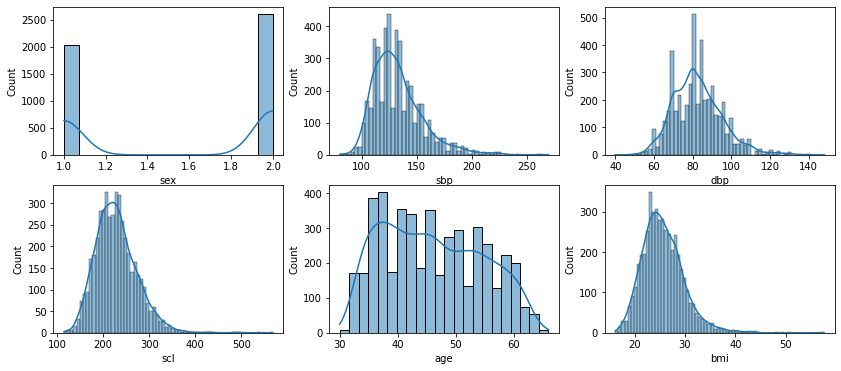

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(14, 6))
sns.histplot(clean["sex"], kde = True, ax = ax[0,0])
sns.histplot(clean["sbp"], kde = True, ax = ax[0,1])
sns.histplot(clean["dbp"], kde = True, ax = ax[0,2])
sns.histplot(clean["scl"], kde = True, ax = ax[1,0])
sns.histplot(clean["age"], kde = True, ax = ax[1,1])
sns.histplot(clean["bmi"], kde = True, ax = ax[1,2])
plt.show()

*It looks like age is not normally distributed and requires transformation.*

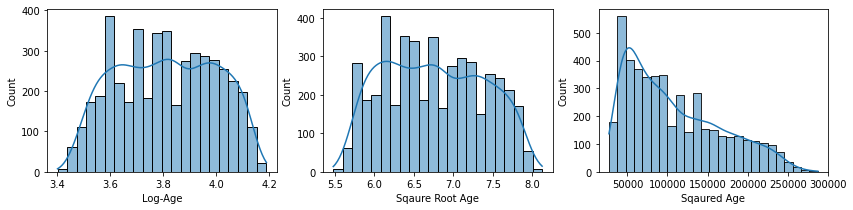

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
sns.histplot(np.log(clean["age"]), kde = True, ax = ax[0])
ax[0].set_xlabel("Log-Age")
sns.histplot(np.power(clean["age"], 0.5), kde = True, ax = ax[1])
ax[1].set_xlabel("Sqaure Root Age")
sns.histplot(np.power(clean["age"], 3), kde = True, ax = ax[2])
ax[2].set_xlabel("Sqaured Age")
plt.show()

*It looks a bit more normal after log-transformation.*

**b. Check to see if collinearity is present. Explain what you find.**  

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(sm.add_constant(X))

,variables,VIF
0,const,98.323182
1,sex,1.024361
2,sbp,2.963621
3,dbp,2.776571
4,scl,1.112047
5,age,1.268649
6,bmi,1.179531
7,season_Summer,1.366088
8,season_Fall,1.526781
9,season_Winter,1.530903


*VIF values of variables are smaller than 5. It means no significant multicollinarity problem in the model. However, __sbp__ and __dbp__ might still need attention as their VIF values are relatively higher.*

In [16]:
clean.drop(["id", "chdfate", "month"], axis = 1).corr()

<ipython-input-16-a2aa26ee346c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  clean.drop(["id", "chdfate", "month"], axis = 1).corr()


,sex,sbp,dbp,scl,age,bmi,season_Fall,season_Spring,season_Summer,season_Winter
sex,1.000000,0.023004,-0.066261,0.022010,0.025283,-0.070689,-0.004495,0.019324,0.010632,-0.022306
sbp,0.023004,1.000000,0.783245,0.217804,0.395648,0.328134,-0.018910,0.032136,-0.024280,0.007433
dbp,-0.066261,0.783245,1.000000,0.194210,0.249443,0.368219,-0.006717,0.008283,0.003082,-0.003636
scl,0.022010,0.217804,0.194210,1.000000,0.280737,0.147246,0.008288,0.030908,-0.022906,-0.019512
age,0.025283,0.395648,0.249443,0.280737,1.000000,0.180467,-0.012381,0.040028,-0.000171,-0.025614
bmi,-0.070689,0.328134,0.368219,0.147246,0.180467,1.000000,0.020134,-0.000085,-0.022388,-0.002230
season_Fall,-0.004495,-0.018910,-0.006717,0.008288,-0.012381,0.020134,1.000000,-0.374892,-0.275257,-0.419748
season_Spring,0.019324,0.032136,0.008283,0.030908,0.040028,-0.000085,-0.374892,1.000000,-0.249677,-0.380739
season_Summer,0.010632,-0.024280,0.003082,-0.022906,-0.000171,-0.022388,-0.275257,-0.249677,1.000000,-0.279551
season_Winter,-0.022306,0.007433,-0.003636,-0.019512,-0.025614,-0.002230,-0.419748,-0.380739,-0.279551,1.000000


*From the correlation matrix, we can see that __dbp__ and __sbp__ has a correlation as high as 0.78. It means that __dbp__ and __sbp__ might have high collinarity in the model, and the assumption of no serious multicollinearity might be violated. One of them should be excluded from the model.*

In [17]:
calc_vif(sm.add_constant(X.drop("dbp", axis = 1)))

,variables,VIF
0,const,90.035638
1,sex,1.009004
2,sbp,1.305183
3,scl,1.108748
4,age,1.248296
5,bmi,1.139442
6,season_Summer,1.363595
7,season_Fall,1.526338
8,season_Winter,1.530897


**c. Check linearity for each of the continuous covariates. Do those covariates each have a linear relationship with the outcome?**

In [18]:
Box_Tidwell = pd.DataFrame()

# Define continuous variables
continuous_var = ["sbp", "dbp", "scl", "age", "bmi"]

# create logit transform interaction terms (natural log) for continuous variables e.g.. age * Log(age)
for var in continuous_var:
    Box_Tidwell[var] = clean[var].apply(lambda x: x)
    Box_Tidwell[f'{var}:Log_{var}'] = clean[var].apply(lambda x: x * np.log(x))

# Building model and fit the data (using statsmodel's Logit)
Box_Tidwell_test = sm.GLM(y, sm.add_constant(Box_Tidwell), family = sm.families.Binomial()).fit()

# Display summary results
Box_Tidwell_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                chdfate   No. Observations:                 4654
Model:                            GLM   Df Residuals:                     4643
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2736.6
Date:                Tue, 08 Nov 2022   Deviance:                       5473.2
Time:                        00:10:26   Pearson chi2:                 4.62e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06673
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.6787      3.382     -5.227      0.000     -24.308     -11.050
sbp             0.0545      0.084      0.649      0.517      -0.110       0.219
sbp:Log_sbp    -0.0081      0.014     -0.580      0.562      -0.036       0.019
dbp             0.0865      0.156      0.555      0.579      -0.219       0.392
dbp:Log_dbp    -0.0141      0.029     -0.495      0.620      -0.070       0.042
scl             0.0291      0.031      0.927      0.354      -0.032       0.090
scl:Log_scl    -0.0036      0.005     -0.740      0.459      -0.013       0.006
age             0.3037      0.223      1.364      0.173      -0.133       0.740
age:Log_age    -0.0594      0.046     -1.294      0.196      -0.149       0.031
bmi             1.0052      0.281      3.575      0.000       0.454       1.556
bmi:Log_bmi    -0.2219      0.065     -3.410      0.001      -0.349      -0.094
===============================================================================
"""

*From the Box Tidwell test above, we see that the coefficient of bmi:Log_bmi is significant. This means that __bmi__ is not linearly related to the logit of the outcome variable and that the assumption of linear logit is violated.*

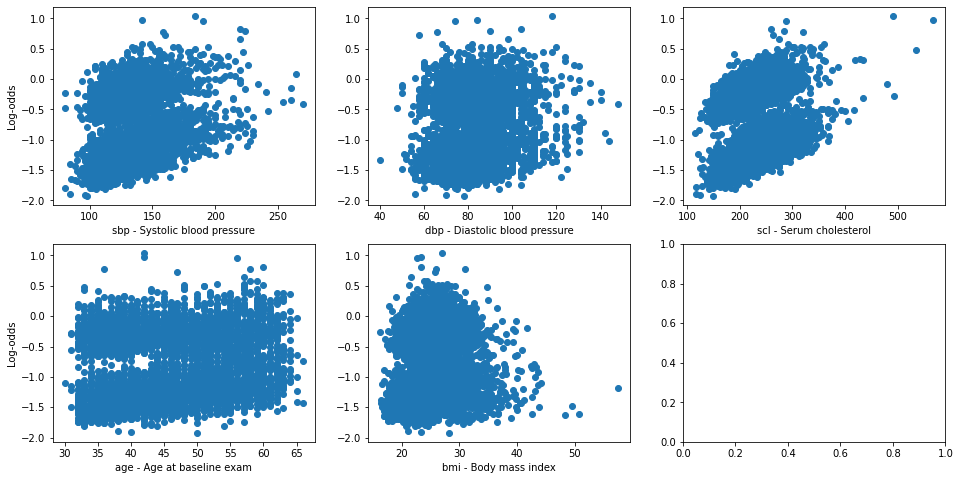

In [19]:
logit_linearity = sm.GLM(y, X, family=sm.families.Binomial()).fit()
predicted = logit_linearity.predict(X)

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))

# Vidualization
f, axes = plt.subplots(2, 3, figsize = (16,8))

# Visualize predictor variable vs logit values for sbp
axes[0,0].scatter(x = sm.add_constant(X)["sbp"].values, y = log_odds)
axes[0,0].set_xlabel("sbp - Systolic blood pressure")
axes[0,0].set_ylabel("Log-odds")

# Visualize predictor variable vs logit values for dbp
axes[0,1].scatter(x = sm.add_constant(X)["dbp"].values, y = log_odds)
axes[0,1].set_xlabel("dbp - Diastolic blood pressure")

# Visualize predictor variable vs logit values for scl
axes[0,2].scatter(x = sm.add_constant(X)["scl"].values, y = log_odds)
axes[0,2].set_xlabel("scl - Serum cholesterol")

# Visualize predictor variable vs logit values for Age
axes[1,0].scatter(x = sm.add_constant(X)["age"].values, y = log_odds)
axes[1,0].set_xlabel("age - Age at baseline exam")
axes[1,0].set_ylabel("Log-odds")

# Visualize predictor variable vs logit values for bmi
axes[1,1].scatter(x = sm.add_constant(X)["bmi"].values, y = log_odds)
axes[1,1].set_xlabel("bmi - Body mass index")

plt.show()

*As the above plots show, __bmi__ does not show a clear linear relationship with the log-odds, which implies that the assumption of logit linearity is violated.*

In [20]:
Box_Tidwell["power_bmi"] = np.power(Box_Tidwell["bmi"],-2)
Box_Tidwell_test_2 = sm.GLM(y, sm.add_constant(Box_Tidwell.drop("bmi", axis = 1)), family = sm.families.Binomial()).fit()

# Display summary results
Box_Tidwell_test_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                chdfate   No. Observations:                 4654
Model:                            GLM   Df Residuals:                     4643
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2735.3
Date:                Tue, 08 Nov 2022   Deviance:                       5470.7
Time:                        00:10:27   Pearson chi2:                 4.62e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06724
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.2685      3.258     -2.538      0.011     -14.654      -1.883
sbp             0.0547      0.084      0.651      0.515      -0.110       0.219
sbp:Log_sbp    -0.0082      0.014     -0.583      0.560      -0.036       0.019
dbp             0.0831      0.156      0.533      0.594      -0.222       0.389
dbp:Log_dbp    -0.0135      0.029     -0.473      0.636      -0.069       0.042
scl             0.0294      0.031      0.938      0.348      -0.032       0.091
scl:Log_scl    -0.0036      0.005     -0.751      0.452      -0.013       0.006
age             0.2957      0.223      1.328      0.184      -0.141       0.732
age:Log_age    -0.0578      0.046     -1.258      0.208      -0.148       0.032
bmi:Log_bmi    -0.0089      0.005     -1.687      0.092      -0.019       0.001
power_bmi    -799.9030    203.563     -3.930      0.000   -1198.880    -400.926
===============================================================================
"""

*It looks like rasing bmi to their negative 2 power would be a good transformation to solve the linearity problem.*

**d. Are there outliers?**  

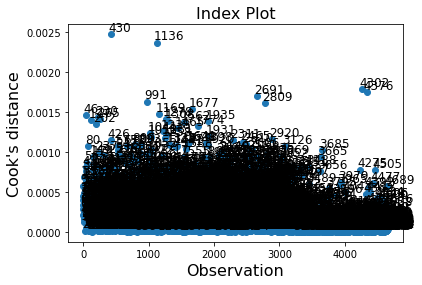

In [21]:
logit.get_influence(observed=True).plot_index()
plt.show()

In [22]:
import scipy.stats as stats

# Get influence measures
influence = logit.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(X)

# Append absolute standardized residual values 
diagnosis_df['std_resid'] = stats.zscore(logit.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]

# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False)

<ipython-input-22-ec4e439b2114>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = stats.zscore(logit.resid_pearson)
<ipython-input-22-ec4e439b2114>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))


,cooks_d,std_resid
1465,0.001301,3.205767
1041,0.001238,3.156493
1931,0.001209,3.324446
1258,0.001175,3.210814
809,0.001102,3.289000
3126,0.001080,3.138920
847,0.000889,3.037781
1734,0.000863,3.055555


*There are many outliers. The above data points shown in table are influential outliers.*

**e. Are there at least 5 outcomes per category of sex?**  

In [23]:
clean[["sex", "chdfate"]].value_counts()

sex  chdfate
2    0          1970
1    0          1221
     1           818
2    1           645
dtype: int64

*Yes, for each category of sex, there are more than 5 CHD cases.*

### 6. Fix any issues you find and refit the model.

In [24]:
fix = clean.copy()

# log transformation of age column
fix["log_age"] = np.log(fix["age"])

# drop influential outliers
fix.drop([1465, 1041, 1931, 1258, 809, 3126, 847, 1734], inplace=True)

# tranformation of non-linear column: bmi
fix["power_bmi"] = np.power(fix["bmi"], -2)

In [25]:
XX = fix[["sex", "sbp", "scl", "log_age", "power_bmi", "season_Summer", "season_Fall", "season_Winter"]]
yy = fix["chdfate"]

In [26]:
logit_fix = sm.GLM(yy, sm.add_constant(XX), family = sm.families.Binomial()).fit()
logit_fix.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                chdfate   No. Observations:                 4646
Model:                            GLM   Df Residuals:                     4637
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2652.4
Date:                Tue, 08 Nov 2022   Deviance:                       5304.9
Time:                        00:10:51   Pearson chi2:                 4.61e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09644
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.1197      0.734     -6.975      0.000      -6.558      -3.681
sex              -0.8001      0.068    -11.774      0.000      -0.933      -0.667
sbp               0.0105      0.002      6.595      0.000       0.007       0.014
scl               0.0068      0.001      8.725      0.000       0.005       0.008
log_age           0.8831      0.199      4.443      0.000       0.494       1.273
power_bmi      -471.9652     76.645     -6.158      0.000    -622.186    -321.744
season_Summer    -0.1088      0.108     -1.009      0.313      -0.320       0.103
season_Fall      -0.1049      0.090     -1.166      0.244      -0.281       0.071
season_Winter    -0.0815      0.089     -0.912      0.362      -0.257       0.094
=================================================================================
"""

### 7. Compute the ORs and their confidence intervals. Interpret the ORs.

In [27]:
# Odds ratio
np.exp(logit_fix.params)

const             5.977943e-03
sex               4.492656e-01
sbp               1.010581e+00
scl               1.006857e+00
log_age           2.418315e+00
power_bmi        1.066879e-205
season_Summer     8.968659e-01
season_Fall       9.004042e-01
season_Winter     9.217316e-01
dtype: float64

- *__sex__ has an OR of 0.449, meaning that females are 0.45 times less likely to experience CHD than males. Put another way, being female is a protecting factor.*  
- *__sbp__ has an OR of 1.011, meaning that for every mm Hg increase in systolic blood pressure, subjects were 1.01 times more likely to experience CHD. In other words, high sbp is a risk factor.*  
- *__scl__ has an OR of 1.006857, meaning that for every mg/100 ml increase in serum cholesterol, subjects were 1.007 times more likely to experience CHD. The OR is extremely close to 0, which suggests that __scl__ is not quite related to odds of CHD.*
- *log_age  has an OR of 2.418. Since log-transformation has been performed, the relationship between age and CHD event cannot be interpreted directly. However, it can be said that for every unit increase in log of age, subjects were 2 times more likely yo experience CHD.*  
- *power_bmi can be interpreted in a similar way as log_age.*  
- *__season_Summer__ has an OR of 0.9. It means that in summer, it is 0.9 times less likely to experience CHD than in spring. Similarly, it is 0.9 times less likely to experience CHD in fall and winnter than in spring. Spring is when it is most likley to see CHD.*

In [31]:
# confidence interval
np.exp(logit_fix.conf_int()).rename(columns={0: "lower bound", 1: "upper bound"})

,lower bound,upper bound
const,1.418281e-03,2.519657e-02
sex,3.932379e-01,5.132759e-01
sbp,1.007425e+00,1.013747e+00
scl,1.005313e+00,1.008404e+00
log_age,1.638103e+00,3.570135e+00
power_bmi,6.136864e-271,1.854742e-140
season_Summer,7.259937e-01,1.107955e+00
season_Fall,7.548381e-01,1.074042e+00
season_Winter,7.736584e-01,1.098145e+00
